# Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [4]:
image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

train_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
valid_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"

test_path="../input/new-plant-diseases-dataset/test/"

In [5]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

# Test data generator (rescaling only)
testdata_generator=ImageDataGenerator(rescale=1./255)

In [6]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test data
test_generator = testdata_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [7]:
class_names = os.listdir(image_path)
print(class_names)
print("Number of classes : {}".format(len(class_names)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [8]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,Tomato___Late_blight,1851
1,Tomato___healthy,1926
2,Grape___healthy,1692
3,Orange___Haunglongbing_(Citrus_greening),2010
4,Soybean___healthy,2022
5,Squash___Powdery_mildew,1736
6,Potato___healthy,1824
7,Corn_(maize)___Northern_Leaf_Blight,1908
8,Tomato___Early_blight,1920
9,Tomato___Septoria_leaf_spot,1745


In [9]:
class_dict = train_generator.class_indices
class_list = list(class_dict.keys())
class_list

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

# MobileNetV2 Model

In [10]:
mobilenetV2_model= tf.keras.applications.MobileNetV2(weights='imagenet',classes=38,include_top=False, input_shape=(224,224, 3))
x= mobilenetV2_model.output
x= GlobalAveragePooling2D()(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.2)(x)
prediction= Dense(38, activation = 'softmax')(x)
model= Model(inputs= mobilenetV2_model.input, outputs= prediction)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,116,070 (15.70 MB)

 Trainable params: 4,080,934 (15.57 MB)

 Non-trainable params: 35,136 (137.25 KB)

In [11]:
callback = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [12]:
history= model.fit(train_generator, 
                   validation_data= validation_generator, 
                   shuffle=True,epochs =20, callbacks=[callback])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/2197 ━━━━━━━━━━━━━━━━━━━━ 39:41:22 65s/step - accuracy: 0.0312 - loss: 4.5728

I0000 00:00:1719088440.364539     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719088440.434922     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1614/2197 ━━━━━━━━━━━━━━━━━━━━ 4:54 505ms/step - accuracy: 0.8067 - loss: 0.6644

W0000 00:00:1719089254.727617     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8286 - loss: 0.5854

W0000 00:00:1719089550.587002     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1279s 553ms/step - accuracy: 0.8287 - loss: 0.5853 - val_accuracy: 0.1418 - val_loss: 14.9766
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 853s 387ms/step - accuracy: 0.9436 - loss: 0.1840 - val_accuracy: 0.3491 - val_loss: 7.6343
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 828s 376ms/step - accuracy: 0.9558 - loss: 0.1420 - val_accuracy: 0.5804 - val_loss: 3.5825
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 831s 377ms/step - accuracy: 0.9648 - loss: 0.1122 - val_accuracy: 0.7906 - val_loss: 1.0600
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 826s 375ms/step - accuracy: 0.9697 - loss: 0.0974 - val_accuracy: 0.7913 - val_loss: 1.0612
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 837s 380ms/step - accuracy: 0.9719 - loss: 0.0875 - val_accuracy: 0.7774 - val_loss: 1.1240
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 824s 374ms/step - accuracy: 0.9776 - loss: 0.0739 - val_accuracy: 0.8401 - val_loss: 0.6526
Epoch 8/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 837s 380ms/step - accuracy: 0

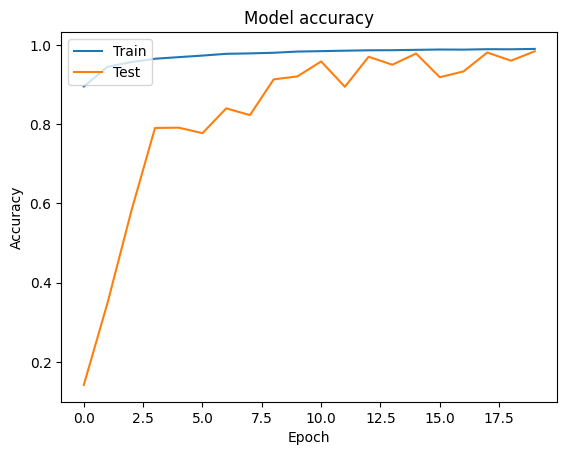

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

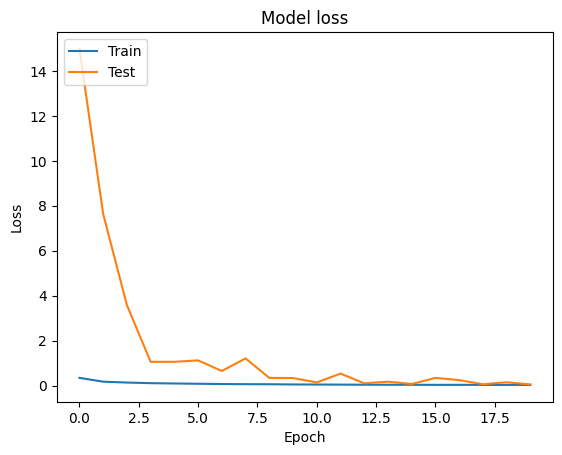

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Saving the model

In [19]:
model.save('detection_model_mobilenetv2.h5')

In [53]:
class_indices = train_generator.class_indices
print(class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [54]:
# Create a list where index matches the class index
class_names = [None] * len(class_indices)
for class_name, index in class_indices.items():
    class_names[index] = class_name

print(class_names)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Probability: 1.00


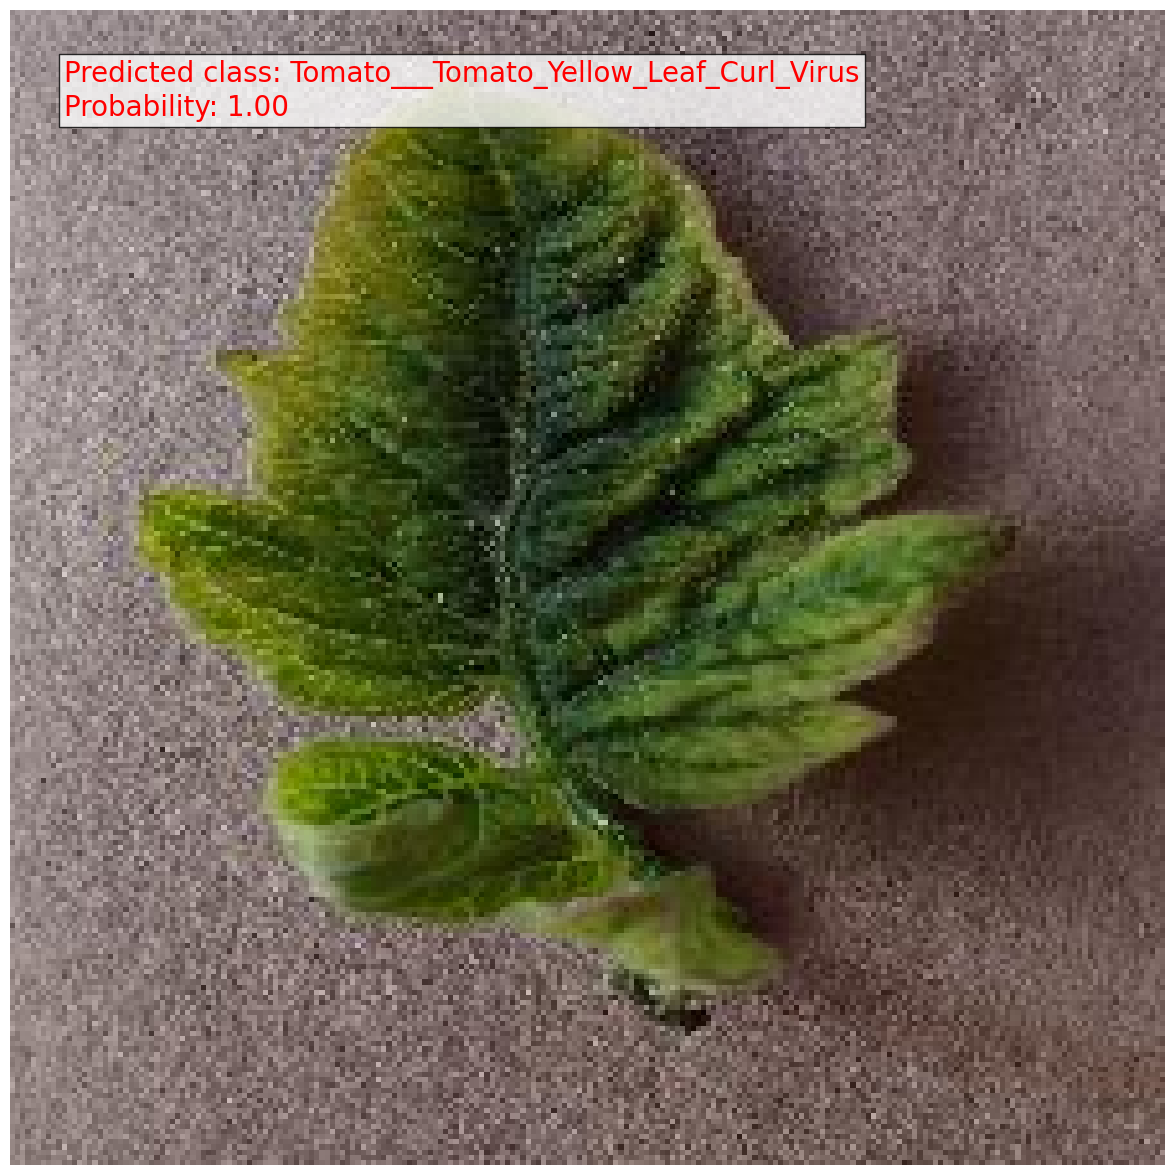

In [57]:
# Set the figure size for the plot
plt.figure(figsize=(15, 15))

# Load and preprocess the image
img_path = '/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus1.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Predict the class probabilities
probs = model.predict(img)[0]

# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = class_names[pred_class_prob]

# Print the predicted class name and probability
print(f'Predicted class: {pred_class_name}')
print(f'Probability: {probs[pred_class_prob]:.2f}')

# Display the image with the predicted class and probability
plt.imshow(img[0])
plt.axis('off')
plt.text(10, 20, f'Predicted class: {pred_class_name}\nProbability: {probs[pred_class_prob]:.2f}', fontsize=20, color='red', bbox=dict(facecolor='white', alpha=0.8))
plt.show()
